In [ ]:
# -*- coding: utf-8 -*-
"""
Trabalho Acadêmico de Ciência de Dados: Fatores de Risco para Doenças Cardíacas
Técnica Principal: Regressão Logística

Este notebook documenta as etapas de análise, pré-processamento, modelagem e avaliação
de um modelo de Regressão Logística para prever a presença de doenças cardíacas
com base em um conjunto de dados de pacientes.
"""

# 1. Informações sobre o Trabalho e Importação de Bibliotecas

# Objetivo:
# Aplicar os conhecimentos adquiridos ao longo do semestre utilizando dados
# reais e técnicas estatísticas para análise, previsão e interpretação de padrões
# relevantes sobre fatores de risco para doenças cardíacas, com foco em Regressão Logística.

# Importação de bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

# Ignorar warnings para melhor visualização do notebook
warnings.filterwarnings('ignore')

# Configuração de estilo para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Diretório para salvar as imagens que serão utilizadas no relatorio posteriormente
import os
output_dir = 'figures'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Diretório '{output_dir}' criado com sucesso para salvar as figuras.")
else:
    print(f"Diretório '{output_dir}' já existe.")

Diretório 'figures' já existe.


Dataset 'heart.csv' carregado com sucesso!

--- Primeiras 5 linhas do Dataset ---
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

--- Informações do Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 1

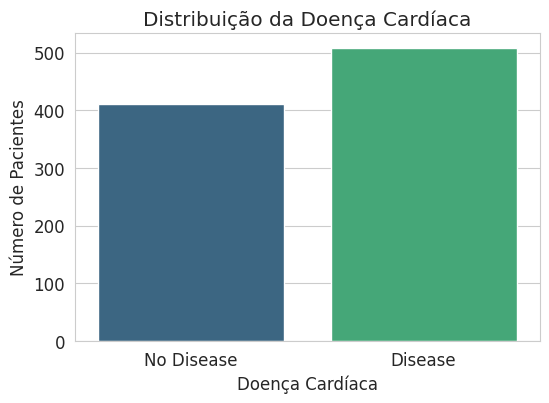

In [ ]:
# 2. Descrição do Conjunto de Dados Utilizado

# Carregar o dataset
try:
    df = pd.read_csv('heart.csv')
    print("Dataset 'heart.csv' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: O arquivo 'heart.csv' não foi encontrado. Certifique-se de que o arquivo está no diretório correto.")
    exit()

# Exibir as primeiras linhas do dataset
print("\n--- Primeiras 5 linhas do Dataset ---")
print(df.head())

# Exibir informações gerais sobre o dataset (tipos de dados, não-nulos)
print("\n--- Informações do Dataset ---")
df.info()

# Exibir estatísticas descritivas das variáveis numéricas
print("\n--- Estatísticas Descritivas das Variáveis Numéricas ---")
print(df.describe())

# Verificar a distribuição da variável alvo (HeartDisease)
print("\n--- Distribuição da Variável Alvo (HeartDisease) ---")
print(df['HeartDisease'].value_counts())
print(df['HeartDisease'].value_counts(normalize=True) * 100)

# Mapear 'HeartDisease' para labels mais descritivas para visualização
df['HeartDisease_Label'] = df['HeartDisease'].map({0: 'No Disease', 1: 'Disease'})

# Visualizar a distribuição da variável alvo
plt.figure(figsize=(6, 4))
sns.countplot(x='HeartDisease_Label', data=df, palette='viridis')
plt.title('Distribuição da Doença Cardíaca')
plt.xlabel('Doença Cardíaca')
plt.ylabel('Número de Pacientes')
plt.savefig(os.path.join(output_dir, 'heartdisease_distribution.png')) # SALVANDO A IMAGEM
plt.show()

# Remover a coluna temporária de label
df = df.drop(columns=['HeartDisease_Label'])

In [ ]:
# 3. Etapas de Limpeza e Tratamento dos Dados

print("\n--- Iniciando Etapas de Limpeza e Tratamento dos Dados ---")

# 3.1. Verificação e Tratamento de Valores Ausentes
print("\nVerificando valores ausentes...")
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print("Não há valores ausentes no dataset.")
else:
    print("Existem valores ausentes. Avalie a estratégia de tratamento.")
    # Exemplo de tratamento: df.dropna(inplace=True) ou df.fillna(df.mean(), inplace=True)

# 3.2. Tratamento de Valores Incomuns ou Zero em RestingBP e Cholesterol
print("\nVerificando e tratando valores zero em 'RestingBP' e 'Cholesterol'...")

# Contar linhas com RestingBP = 0
restingbp_zeros = df[df['RestingBP'] == 0].shape[0]
print(f"Número de linhas com 'RestingBP' igual a zero: {restingbp_zeros}")

# Contar linhas com Cholesterol = 0
cholesterol_zeros = df[df['Cholesterol'] == 0].shape[0]
print(f"Número de linhas com 'Cholesterol' igual a zero: {cholesterol_zeros}")

# Remover linhas onde RestingBP é 0 ou Cholesterol é 0
# A pressão sanguínea e o colesterol não podem ser zero clinicamente.
df_cleaned = df[(df['RestingBP'] != 0) & (df['Cholesterol'] != 0)].copy()

print(f"Número de linhas antes da remoção: {df.shape[0]}")
print(f"Número de linhas após remoção de zeros em RestingBP/Cholesterol: {df_cleaned.shape[0]}")
print(f"Total de linhas removidas: {df.shape[0] - df_cleaned.shape[0]}")

# Atualizar o DataFrame para o dataframe limpo
df = df_cleaned
print("\nDataset após remoção de valores zeros irrealistas.")

# 3.3. Codificação de Variáveis Categóricas
print("\nCodificando variáveis categóricas...")

# Mapear variáveis binárias categóricas para numérico (se ainda não forem)
# 'Sex': Mapear 'M' para 1 e 'F' para 0. O dataset original já vem com 0 e 1, mas é bom verificar.
# 'ExerciseAngina': Mapear 'Y' para 1 e 0.
# 'FastingBS' já é 0 ou 1.

# Verificação dos valores únicos para 'Sex' e 'ExerciseAngina' antes de qualquer mapeamento
print(f"\nValores únicos em 'Sex': {df['Sex'].unique()}")
print(f"Valores únicos em 'ExerciseAngina': {df['ExerciseAngina'].unique()}")

# Se 'Sex' for categórico 'M'/'F', mapear:
if 'M' in df['Sex'].unique() or 'F' in df['Sex'].unique():
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    print("Variável 'Sex' mapeada para 0 e 1.")
else:
    print("Variável 'Sex' já está em formato numérico (0 ou 1).")

# Se 'ExerciseAngina' for categórico 'Y'/'N', mapear:
if 'Y' in df['ExerciseAngina'].unique() or 'N' in df['ExerciseAngina'].unique():
    df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})
    print("Variável 'ExerciseAngina' mapeada para 0 e 1.")
else:
    print("Variável 'ExerciseAngina' já está em formato numérico (0 ou 1).")


# Identificar variáveis categóricas para One-Hot Encoding
# Mantemos 'RestingECG', 'ST_Slope' com drop_first=True para evitar multicolinearidade nessas.
# Para 'ChestPainType', NÃO usaremos drop_first=True para que ASY seja visível.
categorical_features_with_drop = ['RestingECG', 'ST_Slope']
categorical_features_no_drop = ['ChestPainType']

print(f"Variáveis para One-Hot Encoding (com drop_first): {categorical_features_with_drop}")
print(f"Variáveis para One-Hot Encoding (sem drop_first para visibilidade): {categorical_features_no_drop}")


# Aplicar One-Hot Encoding para as que terão drop_first=True
df = pd.get_dummies(df, columns=categorical_features_with_drop, drop_first=True, dtype=int)

# Aplicar One-Hot Encoding para ChestPainType SEM drop_first=True
df = pd.get_dummies(df, columns=categorical_features_no_drop, drop_first=False, dtype=int)

print("\nDataset após One-Hot Encoding:")
print(df.head())
print(f"Novas dimensões do dataset: {df.shape}")

# Exibir os tipos de dados após o tratamento
print("\n--- Informações do Dataset após Limpeza e Tratamento ---\n")
df.info()


--- Iniciando Etapas de Limpeza e Tratamento dos Dados ---

Verificando valores ausentes...
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64
Não há valores ausentes no dataset.

Verificando e tratando valores zero em 'RestingBP' e 'Cholesterol'...
Número de linhas com 'RestingBP' igual a zero: 1
Número de linhas com 'Cholesterol' igual a zero: 172
Número de linhas antes da remoção: 918
Número de linhas após remoção de zeros em RestingBP/Cholesterol: 746
Total de linhas removidas: 172

Dataset após remoção de valores zeros irrealistas.

Codificando variáveis categóricas...

Valores únicos em 'Sex': ['M' 'F']
Valores únicos em 'ExerciseAngina': ['N' 'Y']
Variável 'Sex' mapeada para 0 e 1.
Variável 'ExerciseAngina' mapeada para 0 e 1.
Variáveis para One-Hot Encoding (com drop_first): ['R


--- Iniciando Análise Exploratória de Dados (AED) ---


Estatísticas Descritivas Detalhadas do Dataset Limpo:

              Age         Sex   RestingBP  Cholesterol   FastingBS  \
count  746.000000  746.000000  746.000000   746.000000  746.000000   
mean    52.882038    0.756032  133.022788   244.635389    0.167560   
std      9.505888    0.429762   17.282750    59.153524    0.373726   
min     28.000000    0.000000   92.000000    85.000000    0.000000   
25%     46.000000    1.000000  120.000000   207.250000    0.000000   
50%     54.000000    1.000000  130.000000   237.000000    0.000000   
75%     59.000000    1.000000  140.000000   275.000000    0.000000   
max     77.000000    1.000000  200.000000   603.000000    1.000000   

            MaxHR  ExerciseAngina     Oldpeak  HeartDisease  \
count  746.000000      746.000000  746.000000    746.000000   
mean   140.226542        0.384718    0.901609      0.477212   
std     24.524107        0.486855    1.072861      0.499816   
min  

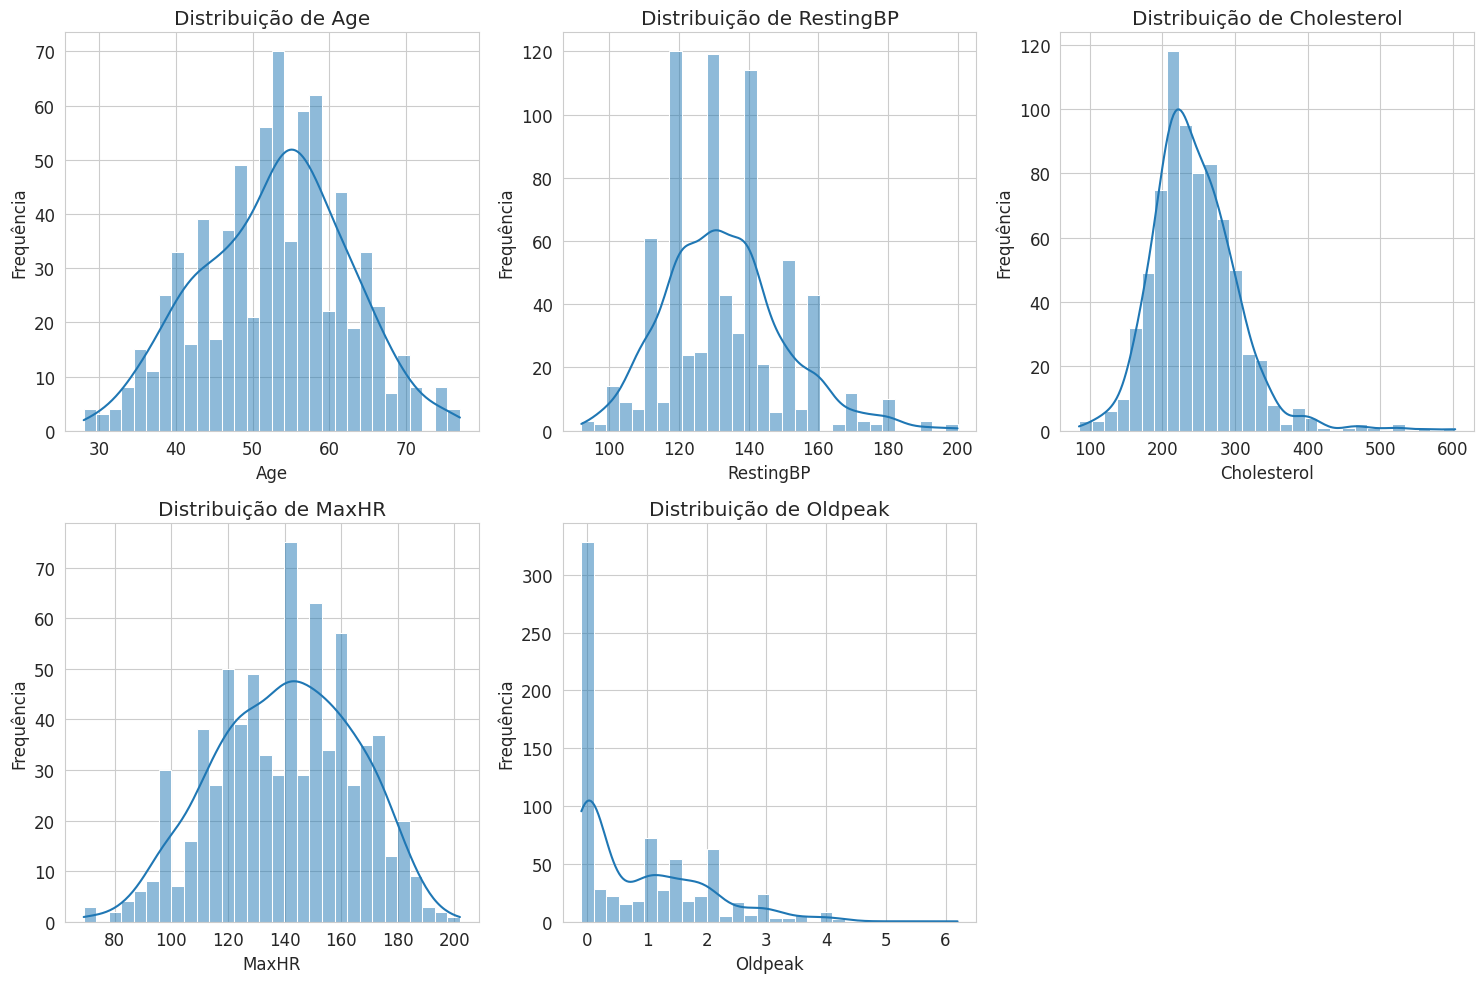

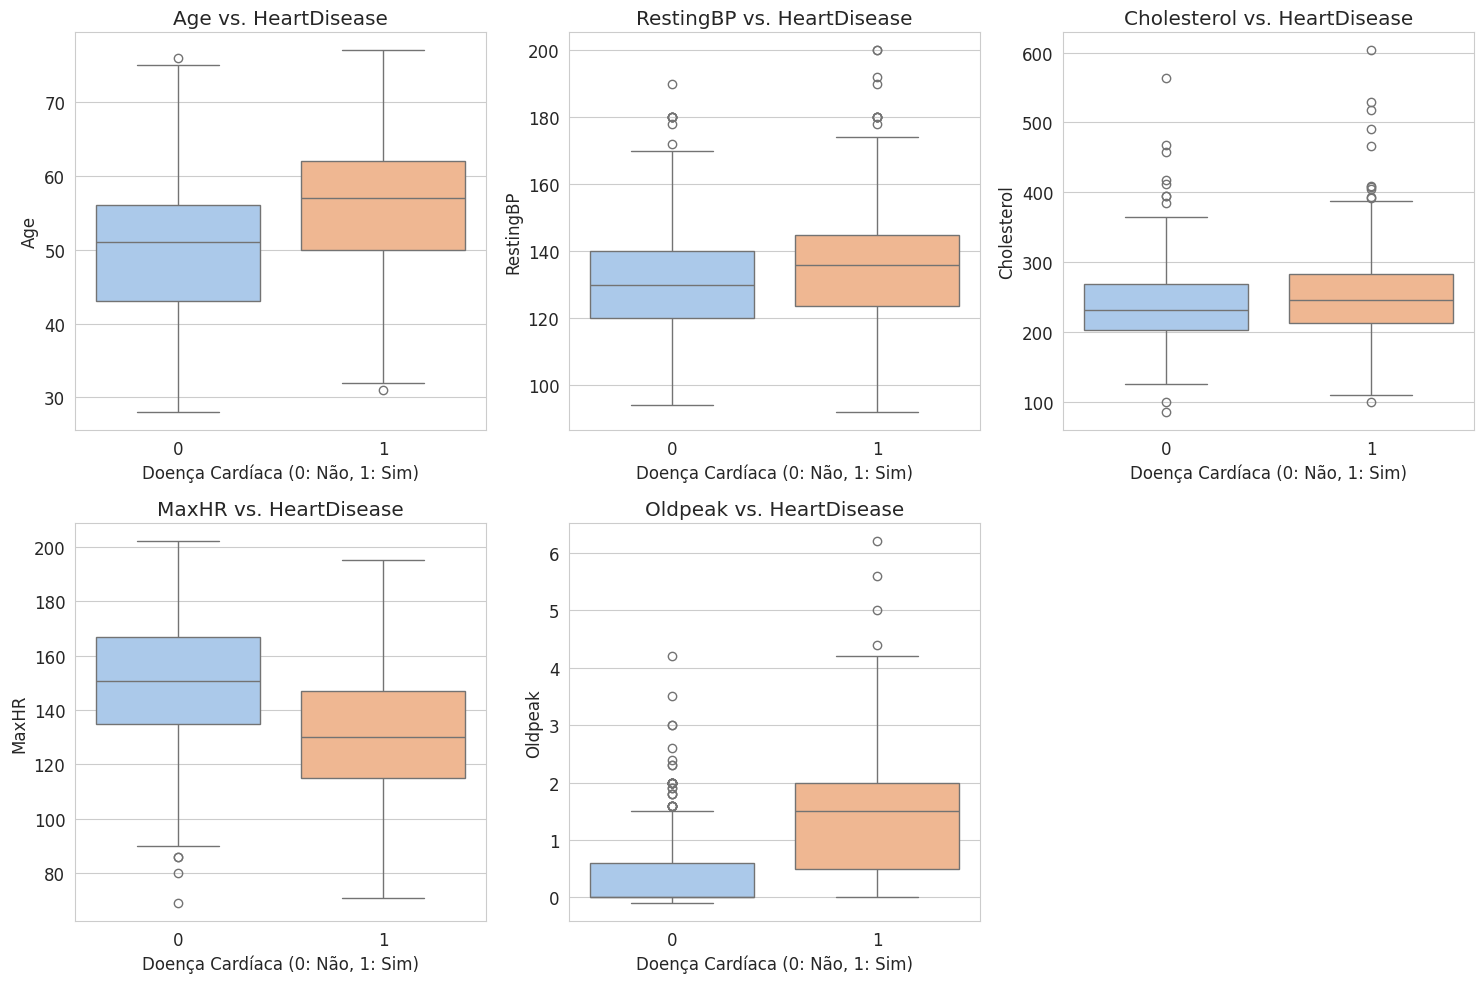

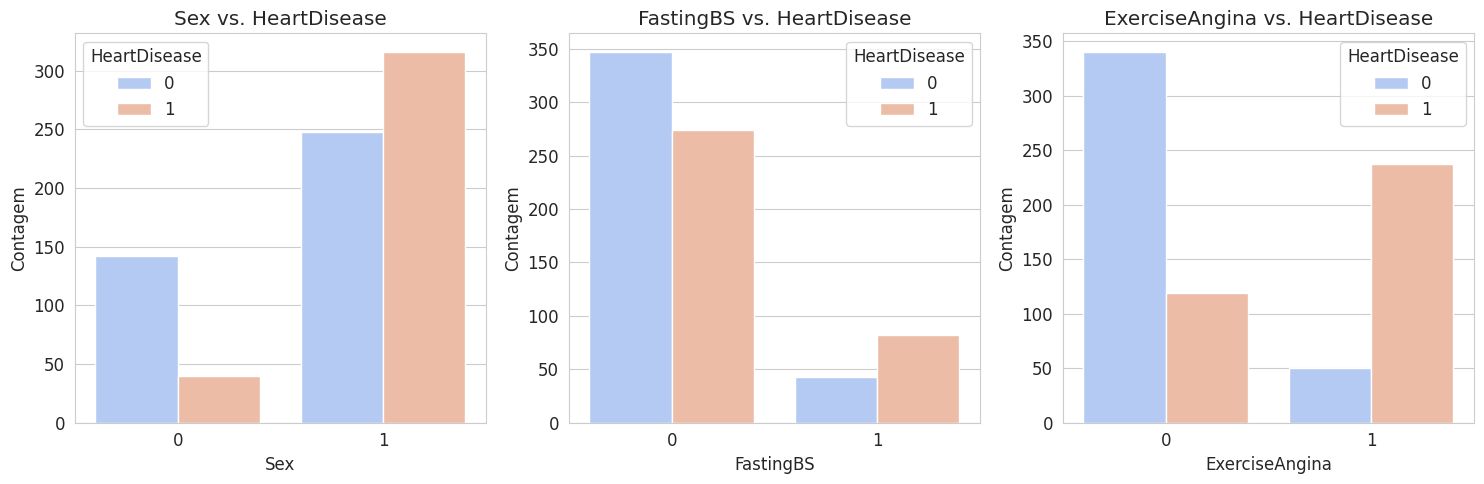

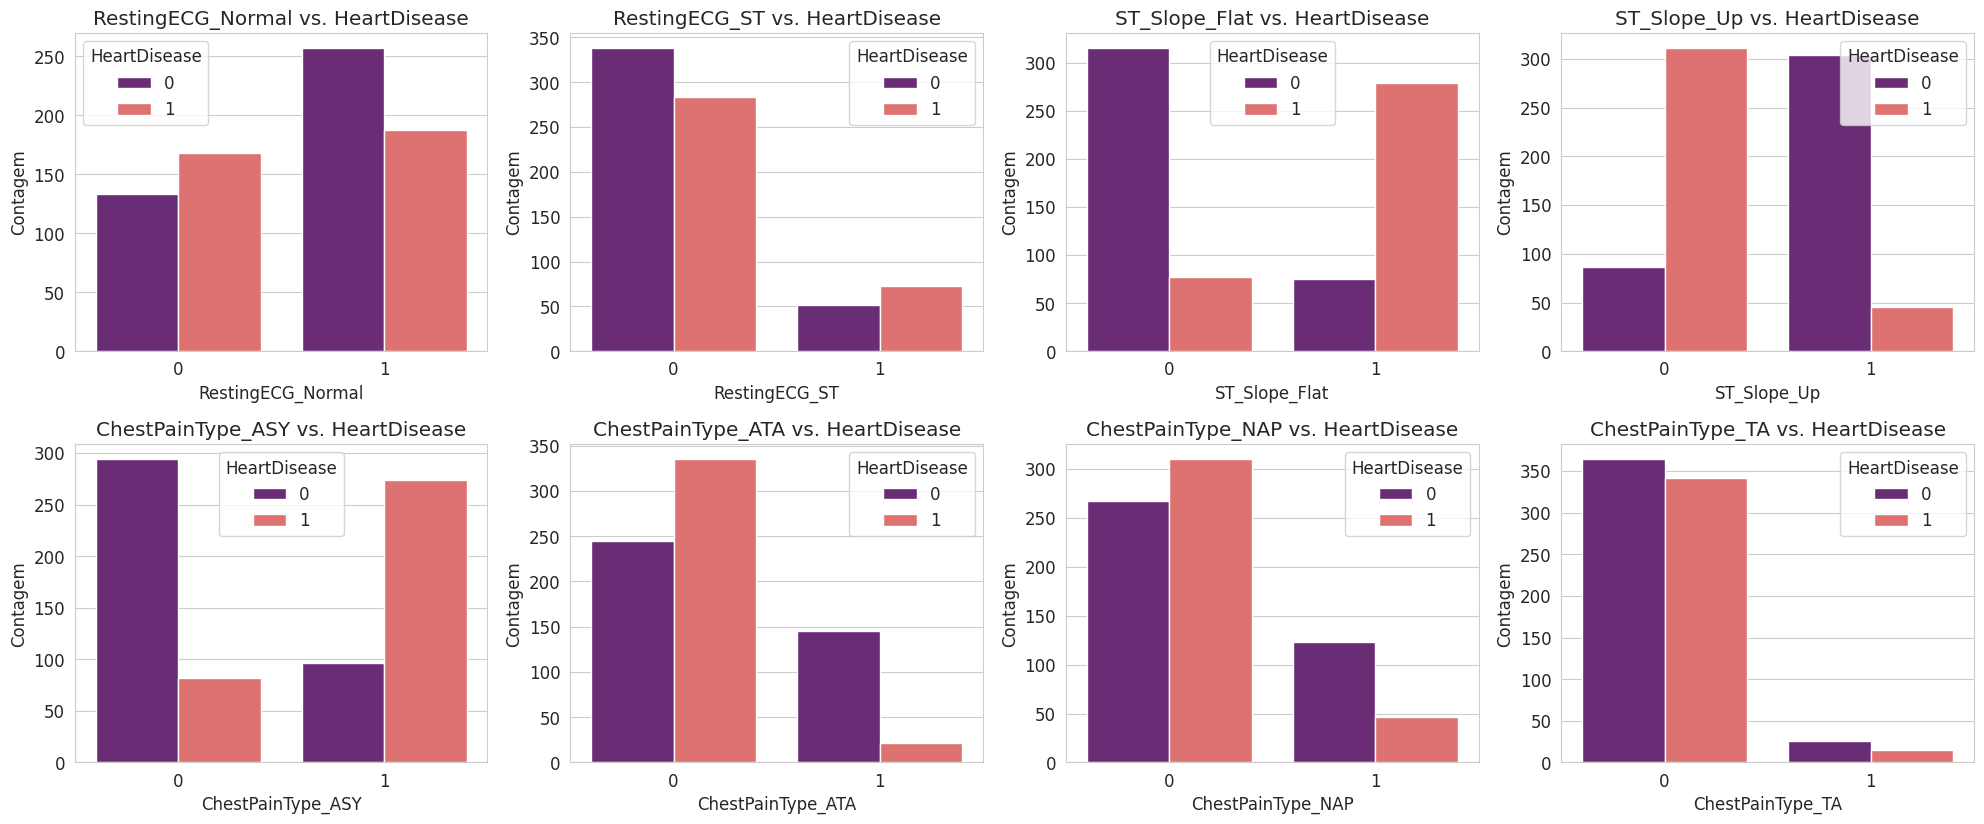


Calculando e visualizando a Matriz de Correlação...



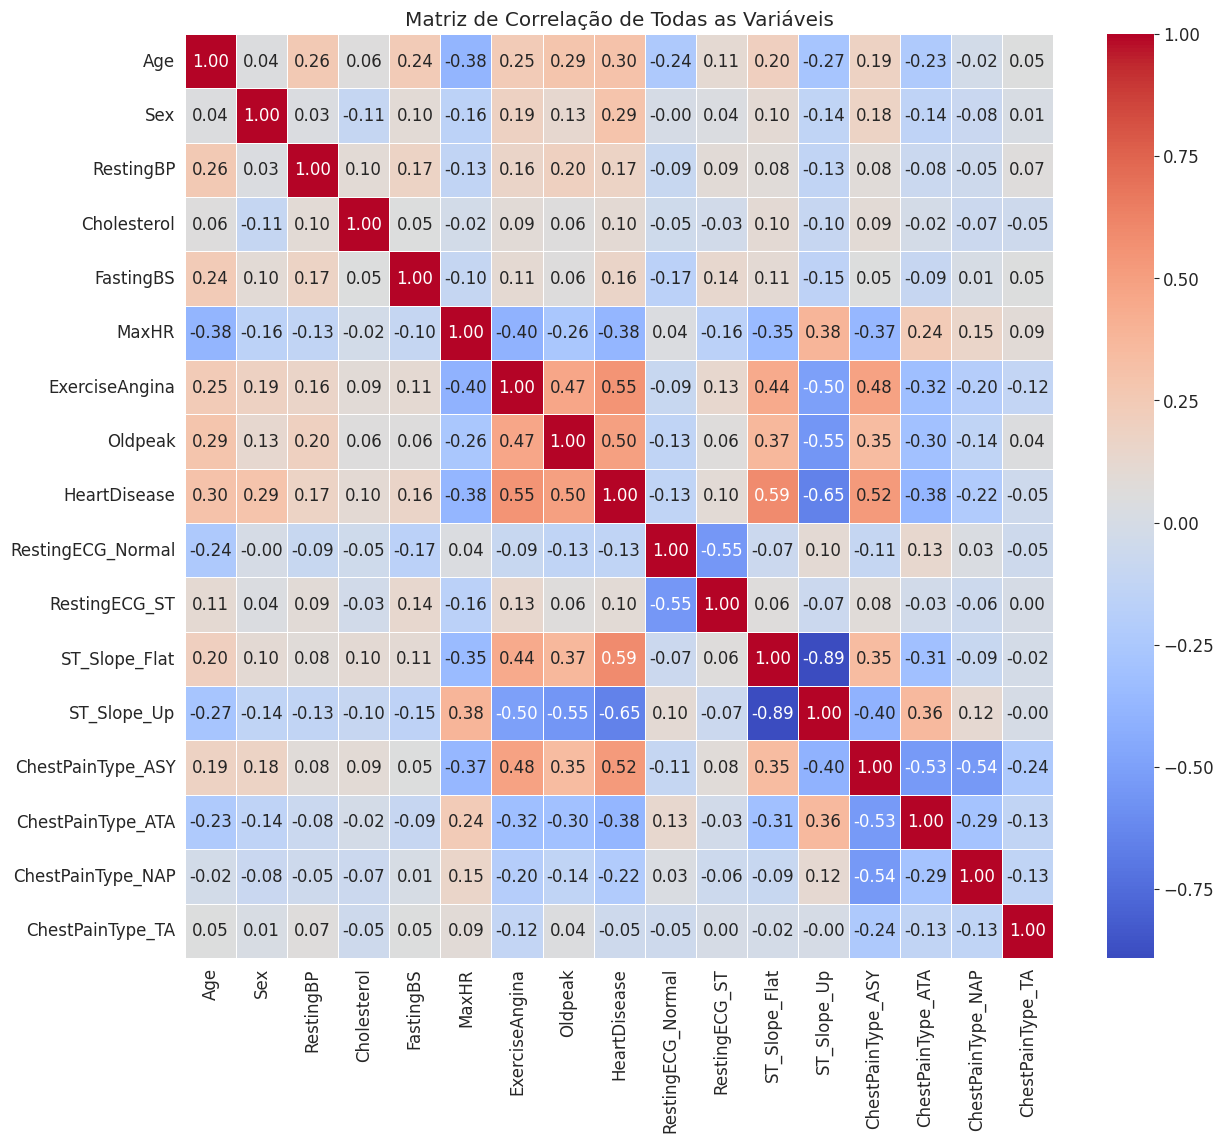


Correlação das variáveis com 'HeartDisease':

HeartDisease         1.000000
ST_Slope_Flat        0.591554
ExerciseAngina       0.551834
ChestPainType_ASY    0.522982
Oldpeak              0.495696
Age                  0.298617
Sex                  0.292779
RestingBP            0.173242
FastingBS            0.160594
Cholesterol          0.103866
RestingECG_ST        0.095921
ChestPainType_TA    -0.053765
RestingECG_Normal   -0.133255
ChestPainType_NAP   -0.222146
ChestPainType_ATA   -0.375634
MaxHR               -0.377212
ST_Slope_Up         -0.653759
Name: HeartDisease, dtype: float64


In [ ]:
# 4. Análise Exploratória (Estatística Descritiva e Gráficos)

print("\n--- Iniciando Análise Exploratória de Dados (AED) ---\n")

# 4.1. Estatística Descritiva das Variáveis Numéricas
print("\nEstatísticas Descritivas Detalhadas do Dataset Limpo:\n")
print(df.describe())

# Identificar colunas numéricas para histogramas e boxplots
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Histograma das variáveis numéricas
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30, palette='viridis')
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'histograms.png')) # SALVANDO A IMAGEM
plt.show()

# 4.2. Análise Bivariada: Relação entre Variáveis e Doença Cardíaca

# Boxplots para variáveis numéricas vs. HeartDisease
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='HeartDisease', y=col, data=df, palette='pastel')
    plt.title(f'{col} vs. HeartDisease')
    plt.xlabel('Doença Cardíaca (0: Não, 1: Sim)')
    plt.ylabel(col)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'numeric_vs_heartdisease_boxplots.png')) # SALVANDO A IMAGEM
plt.show()

# Análise de variáveis categóricas (após one-hot encoding para visualização) vs. HeartDisease
binary_features = ['Sex', 'FastingBS', 'ExerciseAngina']
plt.figure(figsize=(15, 5))
for i, col in enumerate(binary_features):
    plt.subplot(1, 3, i + 1)
    sns.countplot(x=col, hue='HeartDisease', data=df, palette='coolwarm')
    plt.title(f'{col} vs. HeartDisease')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'binary_vs_heartdisease_countplots.png')) # SALVANDO A IMAGEM
plt.show()

# Para as colunas geradas pelo OneHotEncoder
categorical_dummy_features = [col for col in df.columns if any(cat in col for cat in ['ChestPainType', 'RestingECG', 'ST_Slope']) and col != 'HeartDisease']

plt.figure(figsize=(20, 12))
for i, col in enumerate(categorical_dummy_features):
    plt.subplot(3, 4, i + 1) # Ajuste o layout conforme necessário
    sns.countplot(x=col, hue='HeartDisease', data=df, palette='magma')
    plt.title(f'{col} vs. HeartDisease')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.xticks(ticks=[0, 1], labels=['0', '1'])
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'dummy_vs_heartdisease_countplots.png')) # SALVANDO A IMAGEM
plt.show()


# 4.3. Matriz de Correlação
print("\nCalculando e visualizando a Matriz de Correlação...\n")
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação de Todas as Variáveis')
plt.savefig(os.path.join(output_dir, 'correlation_matrix.png')) # SALVANDO A IMAGEM
plt.show()

# Correlação com a variável alvo 'HeartDisease'
print("\nCorrelação das variáveis com 'HeartDisease':\n")
print(correlation_matrix['HeartDisease'].sort_values(ascending=False))



--- Iniciando Aplicação da Regressão Logística ---


Dimensões de X: (746, 16)
Dimensões de y: (746,)


Dimensões do conjunto de treino (X_train, y_train): (522, 16), (522,)
Dimensões do conjunto de teste (X_test, y_test): (224, 16), (224,)


Treinando o Modelo de Regressão Logística...

Treinamento concluído.


Realizando previsões no conjunto de teste e avaliando o modelo...


--- Métricas de Avaliação do Modelo ---

Acurácia: 0.8527
Precisão: 0.8304
Recall: 0.8692
F1-Score: 0.8493
AUC ROC: 0.9237

Matriz de Confusão:

[[98 19]
 [14 93]]


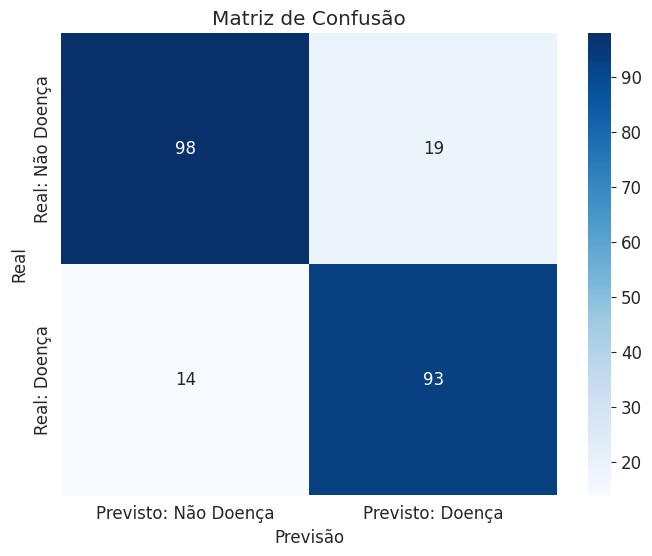

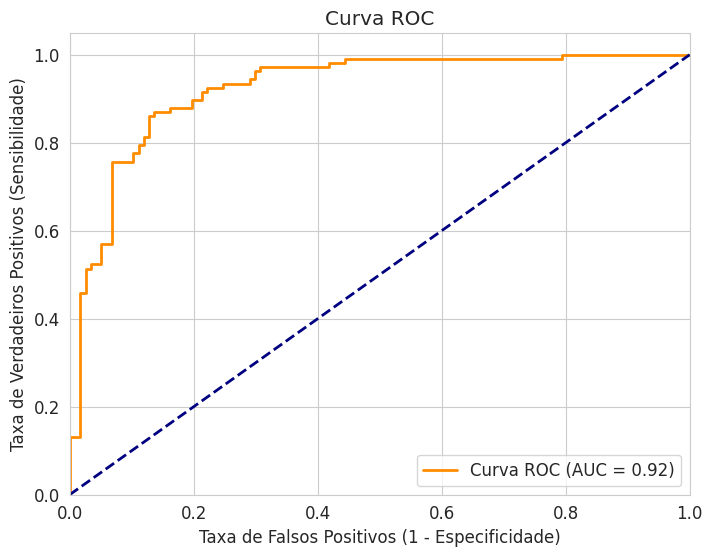

In [ ]:
# 5. Aplicação da Técnica Estatística ou Preditiva: Regressão Logística

print("\n--- Iniciando Aplicação da Regressão Logística ---\n")

# Separar features (X) e target (y)
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print(f"\nDimensões de X: {X.shape}")
print(f"Dimensões de y: {y.shape}\n")

# 5.1. Divisão dos Dados em Conjunto de Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y garante que a proporção de HeartDisease seja a mesma nos conjuntos de treino e teste.

print(f"\nDimensões do conjunto de treino (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensões do conjunto de teste (X_test, y_test): {X_test.shape}, {y_test.shape}\n")

# 5.2. Escalonamento das Variáveis Numéricas e Pipeline para Pré-processamento
# Identificar colunas numéricas para escalonamento
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Criar um ColumnTransformer para aplicar transformações diferentes a diferentes tipos de colunas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough' # Manter as outras colunas (já dummificadas) como estão
)

# Criar o Pipeline: pré-processamento + Regressão Logística
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# 5.3. Treinamento do Modelo de Regressão Logística
print("\nTreinando o Modelo de Regressão Logística...\n")
model_pipeline.fit(X_train, y_train)
print("Treinamento concluído.\n")

# 5.4. Previsão e Avaliação do Modelo
print("\nRealizando previsões no conjunto de teste e avaliando o modelo...\n")
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probabilidades para a classe positiva

# Calcular métricas de avaliação
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Métricas de Avaliação do Modelo ---\n")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC ROC: {roc_auc:.4f}")

print("\nMatriz de Confusão:\n")
print(conf_matrix)

# Visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto: Não Doença', 'Previsto: Doença'],
            yticklabels=['Real: Não Doença', 'Real: Doença'])
plt.xlabel('Previsão')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png')) # SALVANDO A IMAGEM
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.savefig(os.path.join(output_dir, 'roc_curve.png')) # SALVANDO A IMAGEM
plt.show()


In [ ]:
# 6. Discussão dos Resultados Obtidos

print("\n--- Discussão dos Resultados Obtidos ---")

# Re-exibir as métricas para a discussão
print("\nResumo das Métricas de Avaliação:")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC ROC: {roc_auc:.4f}")
print("\nMatriz de Confusão:")
print(conf_matrix)

print("\nInterpretação da Matriz de Confusão:")
tn, fp, fn, tp = conf_matrix.ravel()
print(f"Verdadeiros Positivos (TP): {tp} (Pacientes com doença cardíaca corretamente identificados)")
print(f"Falsos Positivos (FP): {fp} (Pacientes sem doença cardíaca erroneamente identificados como tendo)")
print(f"Falsos Negativos (FN): {fn} (Pacientes com doença cardíaca não identificados)")
print(f"Verdadeiros Negativos (TN): {tn} (Pacientes sem doença cardíaca corretamente identificados como não tendo)")


# Interpretação dos Coeficientes da Regressão Logística
print("\n--- Interpretação dos Coeficientes da Regressão Logística ---")

# Obter os nomes das colunas após o preprocessor (escalonamento e one-hot encoding)
# Pegar as colunas numéricas escalonadas e as colunas categóricas dummificadas (passadas diretamente)
feature_names = numerical_cols + [col for col in X_train.columns if col not in numerical_cols]
# As colunas dummificadas são adicionadas como 'remainder' no preprocessor, mantendo seus nomes originais.

# A ordem das colunas no preprocessor é importante.
# Primeiro as numéricas (escalonadas), depois as restantes (dummificadas).
# Se o OneHotEncoder tivesse sido aplicado dentro do ColumnTransformer, os nomes seriam diferentes.
# Como aplicamos pd.get_dummies antes, os nomes das colunas no X já são os nomes finais.

# Obter os coeficientes do modelo treinado
coefficients = model_pipeline.named_steps['classifier'].coef_[0]
intercept = model_pipeline.named_steps['classifier'].intercept_[0]

# Criar um DataFrame para melhor visualização
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns, # As colunas de X_train já estão na ordem correta após o pré-processamento
    'Coefficient': coefficients
})

print("\nCoeficientes do Modelo de Regressão Logística:")
print(coefficients_df.sort_values(by='Coefficient', ascending=False))
print(f"\nIntercept (Bias): {intercept:.4f}")

print("\nAnálise dos Coeficientes (exemplo de interpretação):")
print("- Coeficientes positivos indicam um aumento na probabilidade de doença cardíaca.")
print("- Coeficientes negativos indicam uma diminuição na probabilidade de doença cardíaca.")
print("- A magnitude do coeficiente reflete a força da influência da variável.")




--- Discussão dos Resultados Obtidos ---

Resumo das Métricas de Avaliação:
Acurácia: 0.8527
Precisão: 0.8304
Recall: 0.8692
F1-Score: 0.8493
AUC ROC: 0.9237

Matriz de Confusão:
[[98 19]
 [14 93]]

Interpretação da Matriz de Confusão:
Verdadeiros Positivos (TP): 93 (Pacientes com doença cardíaca corretamente identificados)
Falsos Positivos (FP): 19 (Pacientes sem doença cardíaca erroneamente identificados como tendo)
Falsos Negativos (FN): 14 (Pacientes com doença cardíaca não identificados)
Verdadeiros Negativos (TN): 98 (Pacientes sem doença cardíaca corretamente identificados como não tendo)

--- Interpretação dos Coeficientes da Regressão Logística ---

Coeficientes do Modelo de Regressão Logística:
              Feature  Coefficient
5               MaxHR     1.656845
10      ST_Slope_Flat     1.231367
7             Oldpeak     0.913840
12  ChestPainType_ASY     0.740513
4           FastingBS     0.407889
0                 Age     0.363090
1                 Sex     0.126455
2    